In [1]:
# Jupyter notebook based on Scott Tse's emergence-response notebook at
# https://github.com/hackoregon/emergency-response/blob/analytics/notebooks/census_eda_geo.ipynb
# Import modules included in "kitchen-sink"
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import psycopg2
import seaborn as sns
import sys
# Import modules NOT included in "kitchen-sink"
from dotenv import load_dotenv, find_dotenv
import geoplot as gplt

%matplotlib inline

In [2]:
# Parameters
# NOTE: password should be an empty string below, instead create a .env file
# that defines the environment variable POSTGRES_PASSWORD=your_password_as_a_string
params = {
    'inputs': {
        'from_database': {
        }
    }
}

In [44]:
# 
def pgconnect():
    """Establish connection to PostGres database using the parameters specified in .env file.
    First, walk root diretory to find and load .env file w/ PostGres variables defining database, 
    user, host, password, and port variables.
    Then, return connection to database from psycopg2.connect
    """
    try:

        load_dotenv(find_dotenv())
        conn = psycopg2.connect(database=os.environ.get("PG_DATABASE"), user=os.environ.get("PG_USER"), 
                            password = os.environ.get("PG_PASSWORD"), 
                            host=os.environ.get("PG_HOST"), port=os.environ.get("PG_PORT"))
        print("Opened database successfully\n")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database\n")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [112]:
def gpd_query(QUERY, geom_col=False):
    '''
    This function takes an SQL query, connects to postgres, 
    and returns either 1) a pandas dataframe, if geom_col is not a string, or
    a geodataframe that also contains a column named geom_col with shape data, 
    typically geom_col='geom'
    NOTE: this combines the functionality of pd_query and gpd_query
    originally written by Scott Tse for emergency response (see link above)
    '''
    conn = pgconnect()
    cur = conn.cursor()
    print("SQL QUERY = "+QUERY+'\r\n')
    try:
        if not isinstance(geom_col, str):
            # Return pandas dataframe, including column names from database
            cur.execute("SET statement_timeout = 0")
            cur.execute(QUERY)
            col_names = [cn[0] for cn in cur.description]
            #for elt in cur.description:
            #col_names.append(elt[0])    
            df = pd.DataFrame(cur.fetchall(), columns=col_names)
            print("Created pandas dataframe!")
            return df
        else:
            geo_df = gpd.GeoDataFrame.from_postgis(QUERY, 
            conn, geom_col=geom_col, crs={'init': u'epsg:4326'}, 
            coerce_float=False)
            print("Created geopandas dataframe using geom_col={}!".format(geom_col))
            return geo_df
    except Exception as e:
        print(e)
    finally:
        conn.close()

In [113]:
# get all rows from loss by neighborhood unit table
QUERY1='''SELECT *
FROM loss_neighborhood_unit_csz_m9p0_dry;
'''
df1 = gpd_query(QUERY1)
df1.info()

# get all rows from loss by neighborhood unit table
QUERY_nu ='''SELECT *
FROM neighborhood_units;
'''
df_nu = gpd_query(QUERY_nu)
df_nu.info()

Opened database successfully

SQL QUERY = SELECT *
FROM loss_neighborhood_unit_csz_m9p0_dry;


Created pandas dataframe!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 22 columns):
objectid         876 non-null int64
nuid             876 non-null int64
bldgloss         876 non-null float64
bldg_lr          876 non-null float64
contentloss      876 non-null int64
debris           876 non-null int64
displacedpop     876 non-null float64
casdaytotal      876 non-null float64
casdayl1         876 non-null float64
casdayl2         876 non-null float64
casdayl3         876 non-null float64
casdayl4         876 non-null float64
casnighttotal    876 non-null float64
casnightl1       876 non-null float64
casnightl2       876 non-null float64
casnightl3       876 non-null float64
casnightl4       876 non-null float64
pdsnone          876 non-null int64
pdsslight        876 non-null int64
pdsmoderate      876 non-null int64
pdsextensive     876 non-nul

In [139]:
# get all rows from loss by neighborhood unit table
QUERY2='''SELECT lc.bldgloss AS buildingloss, 
    lc.bldg_lr AS buildingloss_ratio,
    (lc.casdaytotal + casnighttotal)/2 AS casualities_avetotal,
    ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
    ST_X(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter_lon,
    ST_Y(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter_lat, 
    nu.county AS county
FROM neighborhood_units nu
INNER JOIN loss_neighborhood_unit_csz_m9p0_dry lc
ON nu.objectid = lc.objectid
ORDER BY casualities_avetotal DESC
'''
df2 = gpd_query(QUERY2, geom_col="geometry")
df2.info()

Opened database successfully

SQL QUERY = SELECT lc.bldgloss AS buildingloss, 
    lc.bldg_lr AS buildingloss_ratio,
    (lc.casdaytotal + casnighttotal)/2 AS casualities_avetotal,
    ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
    ST_X(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter_lon,
    ST_Y(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter_lat, 
    nu.county AS county
FROM neighborhood_units nu
INNER JOIN loss_neighborhood_unit_csz_m9p0_dry lc
ON nu.objectid = lc.objectid
ORDER BY casualities_avetotal DESC


Created geopandas dataframe using geom_col=geometry!
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 7 columns):
buildingloss            876 non-null float64
buildingloss_ratio      876 non-null float64
casualities_avetotal    876 non-null float64
geometry                876 non-null object
nucenter_lon            876 non-null float64
nucenter_lat            876 non-null float64
county      

In [140]:
print(df2.shape)
print(df2[['nucenter_lon', 'nucenter_lat']])

(876, 7)
     nucenter_lon  nucenter_lat
0     -122.682017     45.515935
1     -122.769580     45.579160
2     -122.588392     45.581688
3     -122.719313     45.612052
4     -122.677412     45.528895
5     -122.673929     45.510032
6     -122.706063     45.560456
7     -122.660937     45.513177
8     -122.690399     45.499586
9     -122.913067     45.545417
10    -122.690743     45.519882
11    -122.694185     45.529039
12    -122.667497     45.534339
13    -122.825426     45.498669
14    -122.655935     45.523725
15    -122.772115     45.607931
16    -122.611172     45.525448
17    -122.670906     45.486852
18    -122.701437     45.538273
19    -122.886297     45.543538
20    -122.727844     45.572671
21    -122.687496     45.530045
22    -122.651958     45.534199
23    -122.669620     45.544991
24    -122.542924     45.400564
25    -122.783552     45.378112
26    -122.753200     45.428740
27    -122.993538     45.511682
28    -122.773605     45.512578
29    -122.615021     45.532630

# Plotting

Text(0.5,1,'Total Casualties from Cascadia EQ')

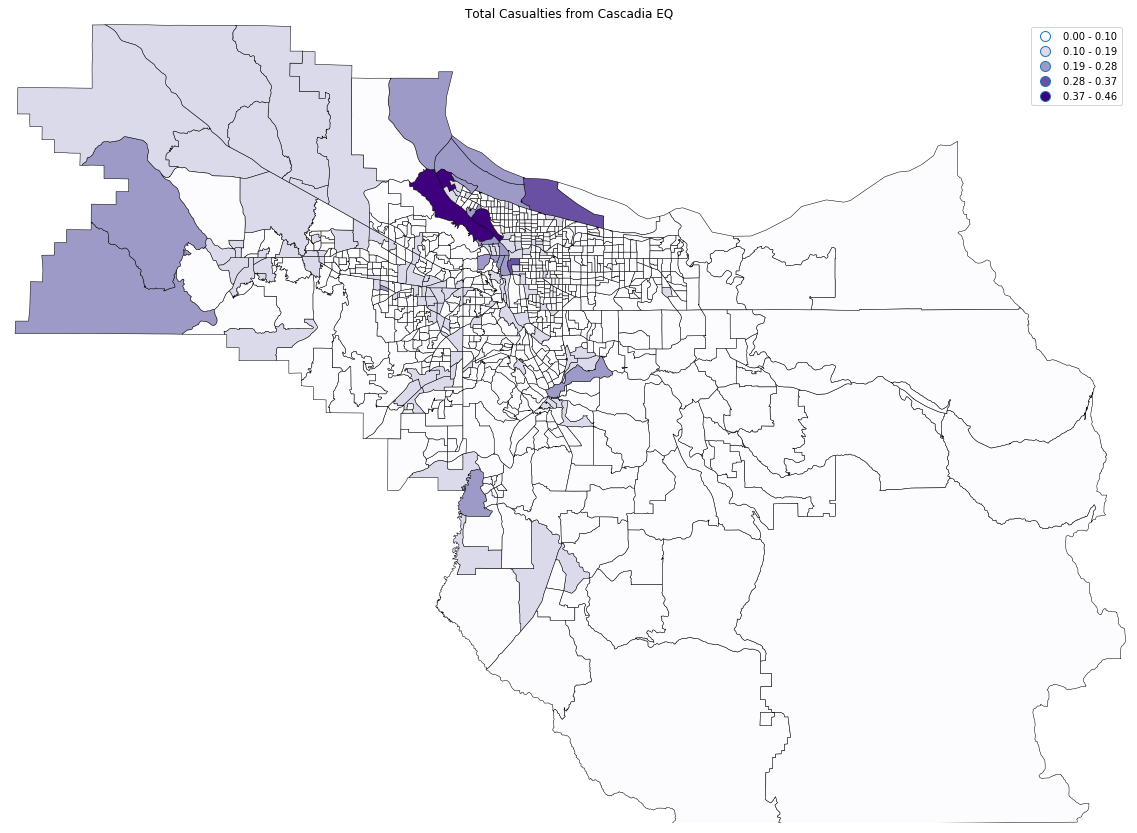

In [127]:
# Make a map showing distribution of df column, col2plot_y
col2plot_x = 'nucenter_lon'
#col2plot_y = 'casualties_avetotal'
#col2plot_y = 'buildingloss'
col2plot_y = 'buildingloss_ratio'
gplt.choropleth(df2,
                hue=df2[col2plot_y],  # Display data, passed as a Series
                projection=gplt.crs.AlbersEqualArea(),
                cmap='Purples',
                linewidth=0.5,
                edgecolor='black',
                k=5,
                legend=True,
                scheme='equal_interval',
                figsize=(20, 20)
)
plt.title("Total Casualties from Cascadia EQ")

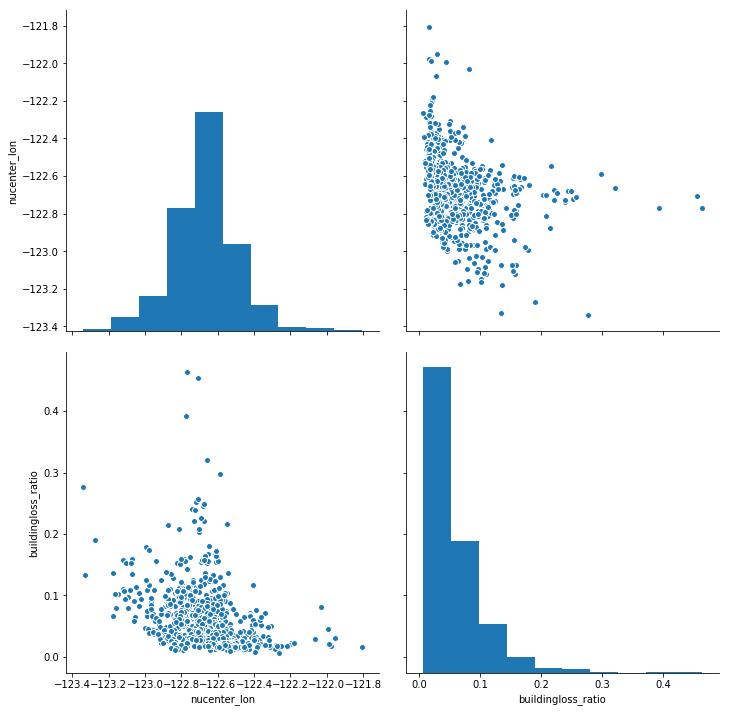

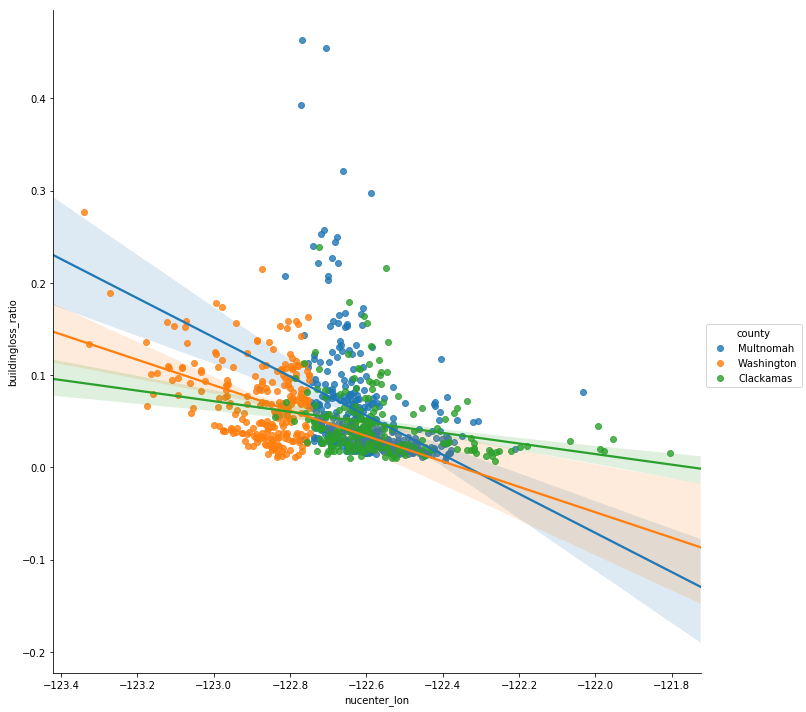

In [138]:
# Plot histograms and scatter plots of col2plot_x and col2plot_y
# then plot scatter plot of col2plot_y vs col2plot_x, with each
# marker color coded by county, and a linear fit to each county group
sns.pairplot(df2, vars = [col2plot_x, col2plot_y], size=5)
sns.lmplot(col2plot_x, col2plot_y, hue="county",
           data=df2,
           fit_reg=True, 
           size=10)